# Assignment 2 Task 1

# Data Prepocessing
* A CNN cannot just eat raw image files of different sizes. It needs uniformly-sized tensors.
* Image pixel values range from 0 to 255 which is not great for traning a neural network. To combat this normalize the values. 

Tools to do this
  * `torchvision.transforms`
  * `transforms.Resize`
  * `transforms.ToTensor`
  * `transforms.Normalize`

In [78]:
from torchvision import transforms

train_dir = "/workspaces/eng-ai-agents/assignments/assignment-2/data/train"
val_dir = "/workspaces/eng-ai-agents/assignments/assignment-2/data/validation"
test_dir = "/workspaces/eng-ai-agents/assignments/assignment-2/data/test"

IMG_SIZE = 224

train_transforms = transforms.Compose(
    [
        # Resize the image to be 224x224
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),

        # Randomly flip the image horizontally (50% chance)
        transforms.RandomHorizontalFlip(p=0.5),
        # Convert the image from a PIL Image to a PyTorch Tensor
        # This also scales pixel values from [0, 255] to [0.0, 1.0]
        transforms.ToTensor(),
        # Normalize the tensor
        # These are the standard mean/std values Taken from pytorch documentation
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# For Validation no augmentation
val_test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)



Putting it togather with ImageFolder and DataLoader

In [79]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=train_dir, 
                            transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, 
                          transform=val_test_transforms)

test_dataset = ImageFolder(root=test_dir, 
                           transform=val_test_transforms)


print(train_dataset.class_to_idx)


# tensor for training loop

BATCH_SIZE = 32 # hyperparameter

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True) # Shuffle training data each epoch

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False) # No need to shuffle validation/test data

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

{'cats': 0, 'dogs': 1}


# Training

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    # Constructor
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Blocks (Conv -> ReLU -> Pool)
        # Block 1
        self.conv1 = nn.Conv2d(
            in_channels=3,  # 3 for RGB images
            out_channels=16,  # 16 filters
            kernel_size=3,  # 3x3 filter
            padding=1,
        )  # Keeps image size the same
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples by 2

        # Dropout to prevent overfitting
        self.dropout1 = nn.Dropout2d(p=0.2)
        
        # Block 2
        self.conv2 = nn.Conv2d(
            in_channels=16,  # Must match out_channels of conv1
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout2 = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.Conv2d(
            in_channels=32,  # Must match out_channels of conv1
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.2)

        # --- Define the Classifier "Head" ---
        # This part flattens the 3D feature map to a 1D vector
        # Example calculation for 224x224 images:
        # 224 -> pool1 -> 112 -> pool2 -> 56 -> pool3 -> 28
        # So the flattened size will be: 64 (channels) * 28 (height) * 28 (width)
        # use nn.Flatten() to do this automatically

        self.flatten = nn.Flatten()

        # 64 channels * 28 H * 28 W = 50,176

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=128)
        self.relu3 = nn.ReLU()
        
        self.dropoutfc1 = nn.Dropout(p=0.5)

        # 1 neuron for binary classification (cat vs. dog)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    # Forward Pass
    def forward(self, x):
        # 'x' is the input batch of images
        # Shape: [batch_size, 3, 224, 224]

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # Shape is [batch_size, 16, 112, 112]
        
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Shape is [batch_size, 32, 56, 56]
        
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        # Shape is [batch_size, 64, 28, 28]
        
        x = self.dropout3(x)
        
        x = self.flatten(x)
        # Shape is [batch_size, 50,176]

        x = self.fc1(x)
        x = self.relu3(x)
        # Shape is [batch_size, 128]
        
        x = self.dropoutfc1(x)

        x = self.fc2(x)
        # Shape is [batch_size, 1]

        return x

In [87]:
model = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=

In [88]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5, verbose=True)

NUM_EPOCHS = 30
BEST_MODEL_PATH = "best_model.pth"
best_val_loss = float("inf")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # model in "training mode"
    model.train()

    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Move data to the GPU
        images = images.to(device)

        # We must unsqueeze the labels to be [batch_size, 1] and make them floats for optimizer
        labels = labels.float().unsqueeze(1).to(device)

        # Zero the gradients (clear old calculations)
        optimizer.zero_grad()

        # Run images through the model
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # calculate gradients with backward pass
        loss.backward()

        # Update the model's weights
        optimizer.step()

        # Track training loss
        running_train_loss += loss.item()

        preds = torch.round(torch.sigmoid(outputs))  # Get 0/1 predictions
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Validation
    model.eval()

    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # don't need to calculate gradients during validation
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))  # Get 0/1 predictions
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

        # Save the model's weights to the file
        torch.save(model.state_dict(), BEST_MODEL_PATH)

        print(f"New best model saved at Epoch {epoch + 1} with Val Loss: {avg_val_loss:.4f}")

    # Append the average values to your lists
    train_losses.append(running_train_loss / len(train_loader))
    val_losses.append(running_val_loss / len(val_loader))
    train_accuracies.append(correct_train / total_train)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}: Train Loss: {running_train_loss} | Val Loss: {running_val_loss}")


New best model saved at Epoch 1 with Val Loss: 0.0212
Epoch 1/30: Train Loss: 45.384453892707825 | Val Loss: 21.223151981830597
New best model saved at Epoch 2 with Val Loss: 0.0206
Epoch 2/30: Train Loss: 42.49133151769638 | Val Loss: 20.597363471984863
New best model saved at Epoch 3 with Val Loss: 0.0202
Epoch 3/30: Train Loss: 42.10017192363739 | Val Loss: 20.242931008338928
Epoch 4/30: Train Loss: 40.642758548259735 | Val Loss: 20.49810740351677
New best model saved at Epoch 5 with Val Loss: 0.0195
Epoch 5/30: Train Loss: 40.6818431019783 | Val Loss: 19.46266746520996
Epoch 6/30: Train Loss: 39.9155276119709 | Val Loss: 20.012984216213226
New best model saved at Epoch 7 with Val Loss: 0.0191
Epoch 7/30: Train Loss: 39.41139116883278 | Val Loss: 19.062883347272873
Epoch 8/30: Train Loss: 37.611830919981 | Val Loss: 19.306577891111374
Epoch 9/30: Train Loss: 38.134422183036804 | Val Loss: 19.39362770318985
New best model saved at Epoch 10 with Val Loss: 0.0187
Epoch 10/30: Train Los

In [89]:

model = SimpleCNN() 
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        # We don't need to unsqueeze or move labels to GPU for this
        all_labels.extend(labels.numpy()) 
        
        outputs = model(images) 
        probs = torch.sigmoid(outputs)

        # If prob > 0.5, output 1 (dog), else 0 (cat)
        preds = torch.round(probs)
        
        # Move predictions to CPU and convert to numpy
        all_predictions.extend(preds.cpu().numpy())




/tmp/ipykernel_906/2891273957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


In [90]:
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

print(confusion_matrix(all_labels, all_predictions))
print(classification_report(all_labels, all_predictions))

input_shape = (3, 224, 224)
summary(model, input_shape)

[[343 157]
 [122 378]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       500
           1       0.71      0.76      0.73       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
         Dropout2d-5         [-1, 16, 112, 112]               0
            Conv2d-6         [-1, 32, 112, 112]           4,640
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              ReLU-8         [-1, 32, 112, 112]               0
         

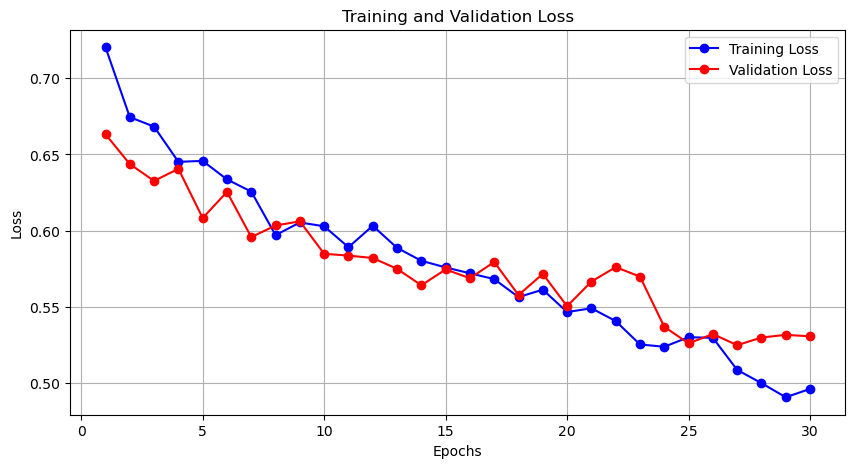

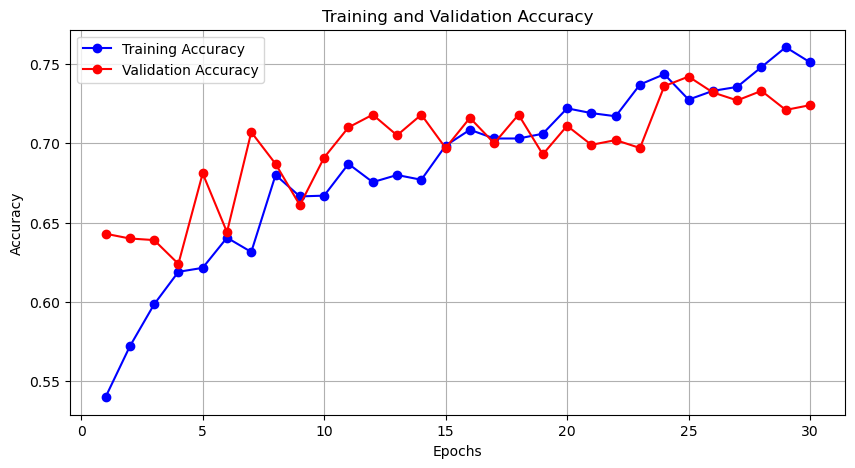

In [91]:
import matplotlib.pyplot as plt

# Get your epoch count
num_epochs_ran = len(train_losses)
epochs = range(1, num_epochs_ran + 1)

# --- 1. Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png') # Save the figure
plt.show()

# --- 2. Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png') # Save the figure
plt.show()